In [10]:
'''The purponse of this notebook is to simulate book reviews in light of C. S. Lewis's assertion that only those who love a genre can accurately judge a
book which belongs to it
'''

from ReviewClasses import *
from matplotlib import pyplot as plt

In [ ]:
work_a = Work(Category.A, merit = 4.2)
work_b = Work(Category.B, merit = 3.6)

work_c = Work(Category.A, merit = 1.5)
work_d = Work(Category.B, merit = 2.5)

works = [work_a, work_b, work_c, work_d]

In [8]:
# assume: work_a, work_b, Reviewer, Category already defined
rng = np.random.default_rng()
num_reviewers = 1000

reviewers = []

for _ in range(num_reviewers):
    # truncated normal between 0 and 5 with mean 3, sd 0.5
    reviewer = Reviewer()
    reviewers.append(reviewer)

for reviewer in reviewers:
    will_review = rng.uniform(0, 5)
    if reviewer.categories[Category.A] > will_review:
        r_a = reviewer.review(work_a)
    if reviewer.categories[Category.B] > will_review:
        r_b = reviewer.review(work_b)

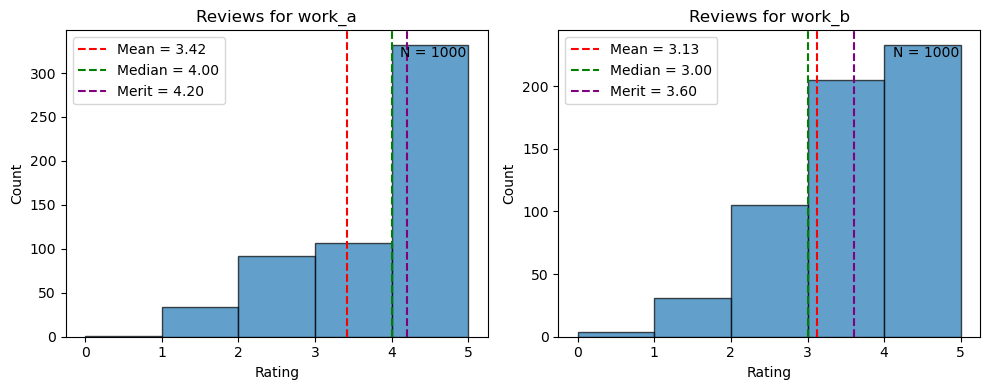

In [11]:
# Assume: work_a, work_b, reviewers, Category, num_reviewers already defined
# and Reviewer.review(work) appends to work.reviews()

# Get ratings directly from works
ratings_a = np.array(work_a.reviews)  # work.reviews() returns list
ratings_b = np.array(work_b.reviews)
ratings_a = np.round(ratings_a)
ratings_b = np.round(ratings_b)

mean_a, median_a = ratings_a.mean(), np.median(ratings_a)
mean_b, median_b = ratings_b.mean(), np.median(ratings_b)

# --------------------------------------------------
# Histograms for ratings with mean/median and N
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# work_a
ax = axes[0]
ax.hist(ratings_a, bins=5, edgecolor="black", alpha=0.7)
ax.set_title("Reviews for work_a")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

ax.axvline(mean_a, color="red", linestyle="--", label=f"Mean = {mean_a:.2f}")
ax.axvline(median_a, color="green", linestyle="--", label=f"Median = {median_a:.2f}")
ax.axvline(work_a.merit, color='purple', linestyle='--', label=f'Merit = {work_a.merit:.2f}')
ax.legend()

ax.text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
)

# work_b
ax = axes[1]
ax.hist(ratings_b, bins=5, edgecolor="black", alpha=0.7)
ax.set_title("Reviews for work_b")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

ax.axvline(mean_b, color="red", linestyle="--", label=f"Mean = {mean_b:.2f}")
ax.axvline(median_b, color="green", linestyle="--", label=f"Median = {median_b:.2f}")
ax.axvline(work_b.merit, color='purple', linestyle='--', label=f'Merit = {work_b.merit:.2f}')
ax.legend()

ax.text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# Category preference distributions
# reviewer.categories: {Category.A: prefA, Category.B: prefB}
# tol is the threshold (you called it `tol` when creating reviewers)
# --------------------------------------------------
prefs_A = np.array([rev.categories[Category.A][0] for rev in reviewers])
prefs_B = np.array([rev.categories[Category.B][0] for rev in reviewers])
tols    = np.array([rev.tol for rev in reviewers])   # assuming Reviewer has .tol

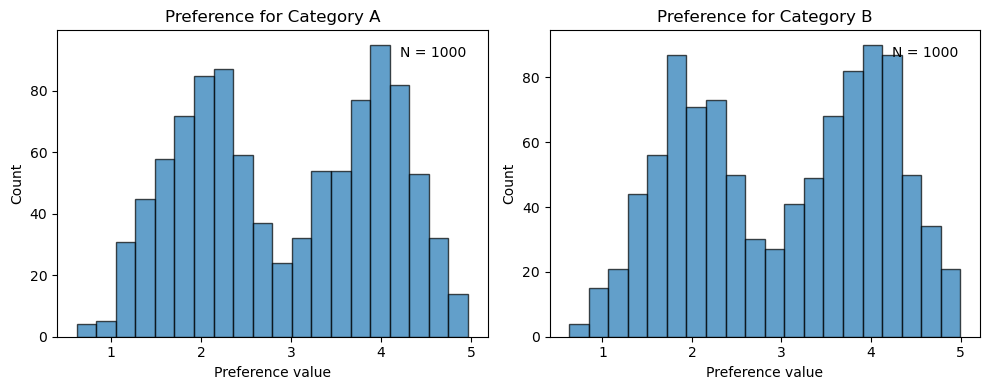

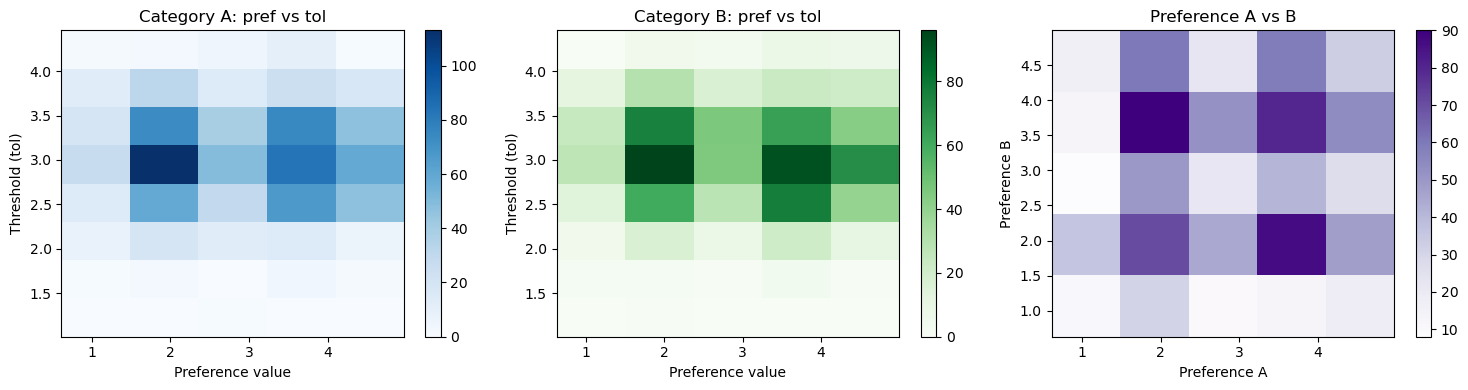

In [12]:
# 1D histograms for A and B with N label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel 1: Category A
axes[0].hist(prefs_A, bins=20, edgecolor="black", alpha=0.7)
axes[0].set_title("Preference for Category A")
axes[0].set_xlabel("Preference value")
axes[0].set_ylabel("Count")
axes[0].text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=axes[0].transAxes,
    ha="right", va="top",
    fontsize=10,
)

# Panel 2: Category B
axes[1].hist(prefs_B, bins=20, edgecolor="black", alpha=0.7)
axes[1].set_title("Preference for Category B")
axes[1].set_xlabel("Preference value")
axes[1].set_ylabel("Count")
axes[1].text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=axes[1].transAxes,
    ha="right", va="top",
    fontsize=10,
)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Category A: pref vs tol
h = axes[0].hist2d(prefs_A, tols, bins=[5, 8], cmap="Blues")  # [web:150][web:157]
axes[0].set_title("Category A: pref vs tol")
axes[0].set_xlabel("Preference value")
axes[0].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[0])

# Category B: pref vs tol
h = axes[1].hist2d(prefs_B, tols, bins=[5, 8], cmap="Greens")
axes[1].set_title("Category B: pref vs tol")
axes[1].set_xlabel("Preference value")
axes[1].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[1])

# Panel 3: 2D histogram of prefs_A vs prefs_B
h = axes[2].hist2d(prefs_A, prefs_B, bins=[5, 5], cmap="Purples")
axes[2].set_title("Preference A vs B")
axes[2].set_xlabel("Preference A")
axes[2].set_ylabel("Preference B")
fig.colorbar(h[3], ax=axes[2])

plt.tight_layout()
plt.show()
